In [8]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

# Load the model

In [2]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)
print('loaded!')

loaded!


In [ ]:
# model

# Load data

In [4]:
dpath = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/"


def load_data(path, sample_size=None):
    """
    Loads data from a file, processes cell types, and returns a DataFrame.

    Args:
        path (str): The path to the dataset file.
        sample_size (int, optional): Number of cells to sample. Defaults to None.
    Returns:
        pandas.DataFrame: The processed DataFrame.
    """

    df = gtu.load_data_as_dataframe(path, num_cells=sample_size, shuffle=True)

    if "iHSC" in path:
        df['cell_type'] = "iHSC"
    elif "pellin" in path:
        df['cell_type'] = df['dataset']
    elif "weng" in path:
        df['cell_type'] = df['STD.CellType']
    else:
        df['cell_type'] = df['free_annotation']

    # Extract basename without extension and assign to 'dataset' column
    df['dataset'] = os.path.splitext(os.path.basename(path))[0]
    df = df[['input_ids', 'cell_type', 'dataset', 'length']]

    return df

sample_size = 1000

df = []

for dataset in os.listdir(dpath):
    
    data_path = f"{dpath}{dataset}"
    tmp = load_data(data_path, sample_size)
    
    df.append(tmp)
    
df = pd.concat(df)
data = Dataset.from_pandas(df)
data

Dataset({
    features: ['input_ids', 'cell_type', 'dataset', 'length', '__index_level_0__'],
    num_rows: 12000
})

100%|██████████| 1200/1200 [05:40<00:00,  3.53it/s]


embs.shape=(12000, 512)


/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


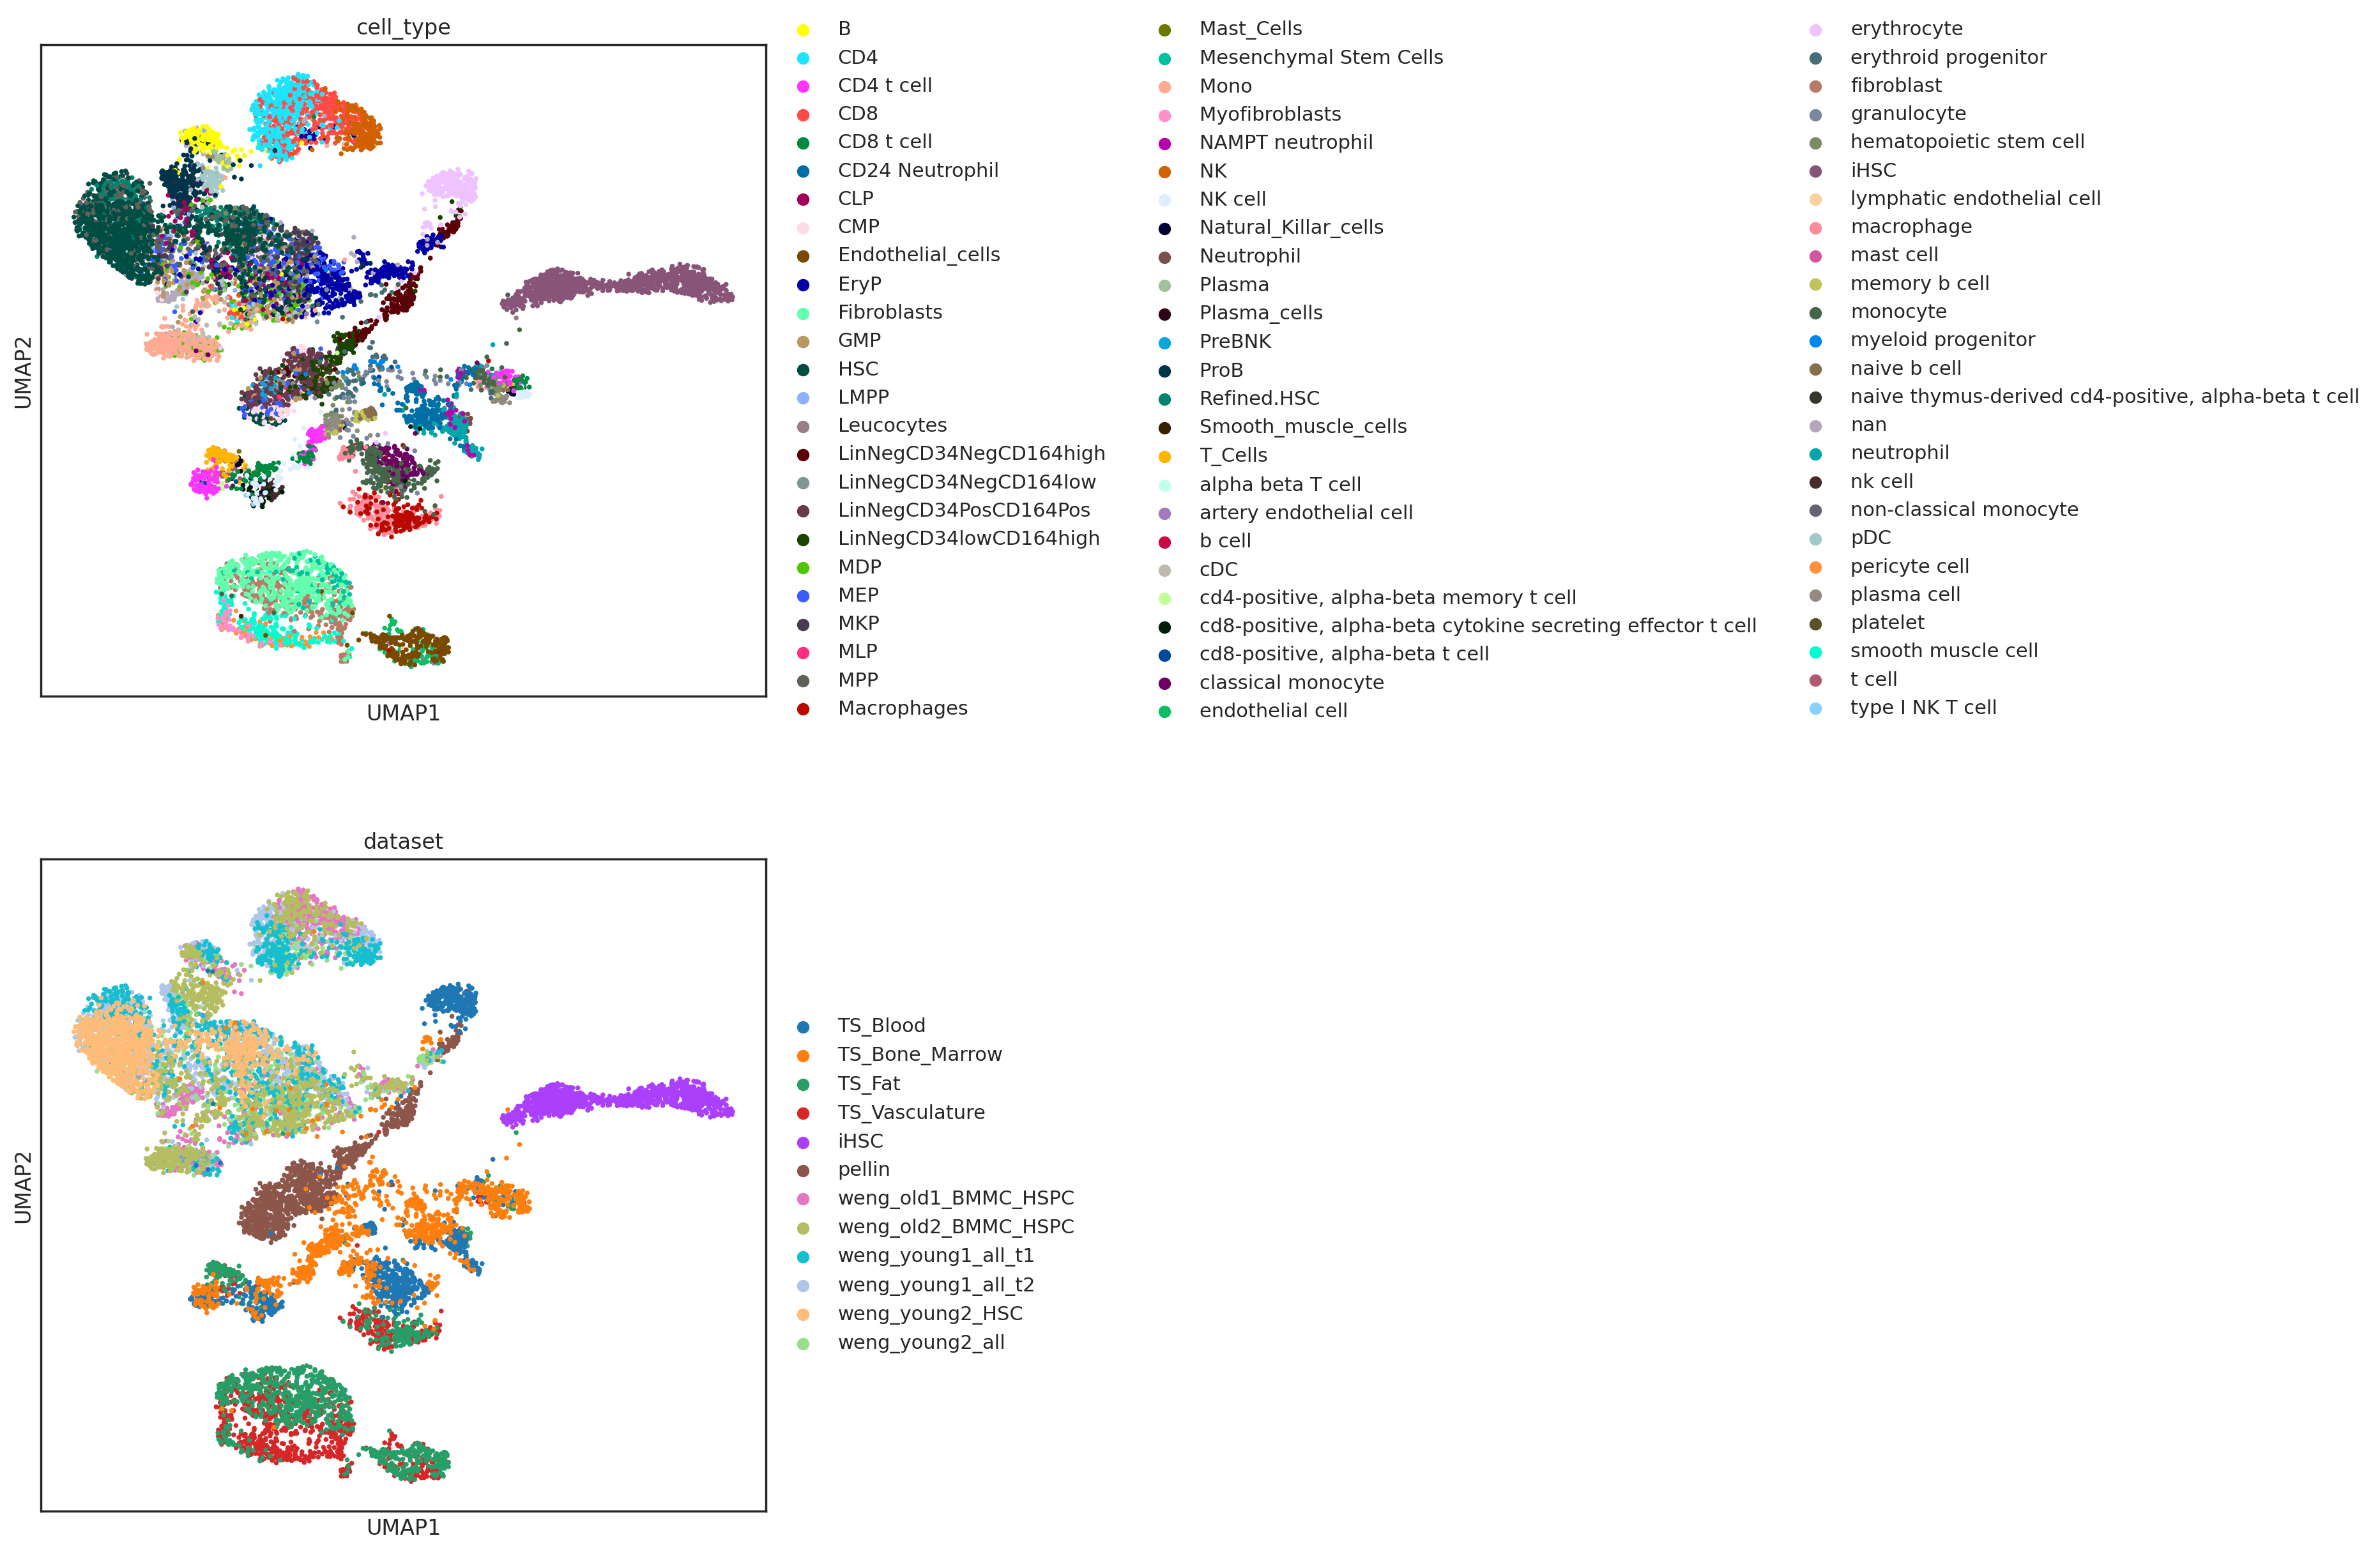

AnnData object with n_obs × n_vars = 12000 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.umap(adata, 
           min_dist=0.75,
          )


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7
8
sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    ncols=1,
    size=30,
)

adata

# Clean up cell types

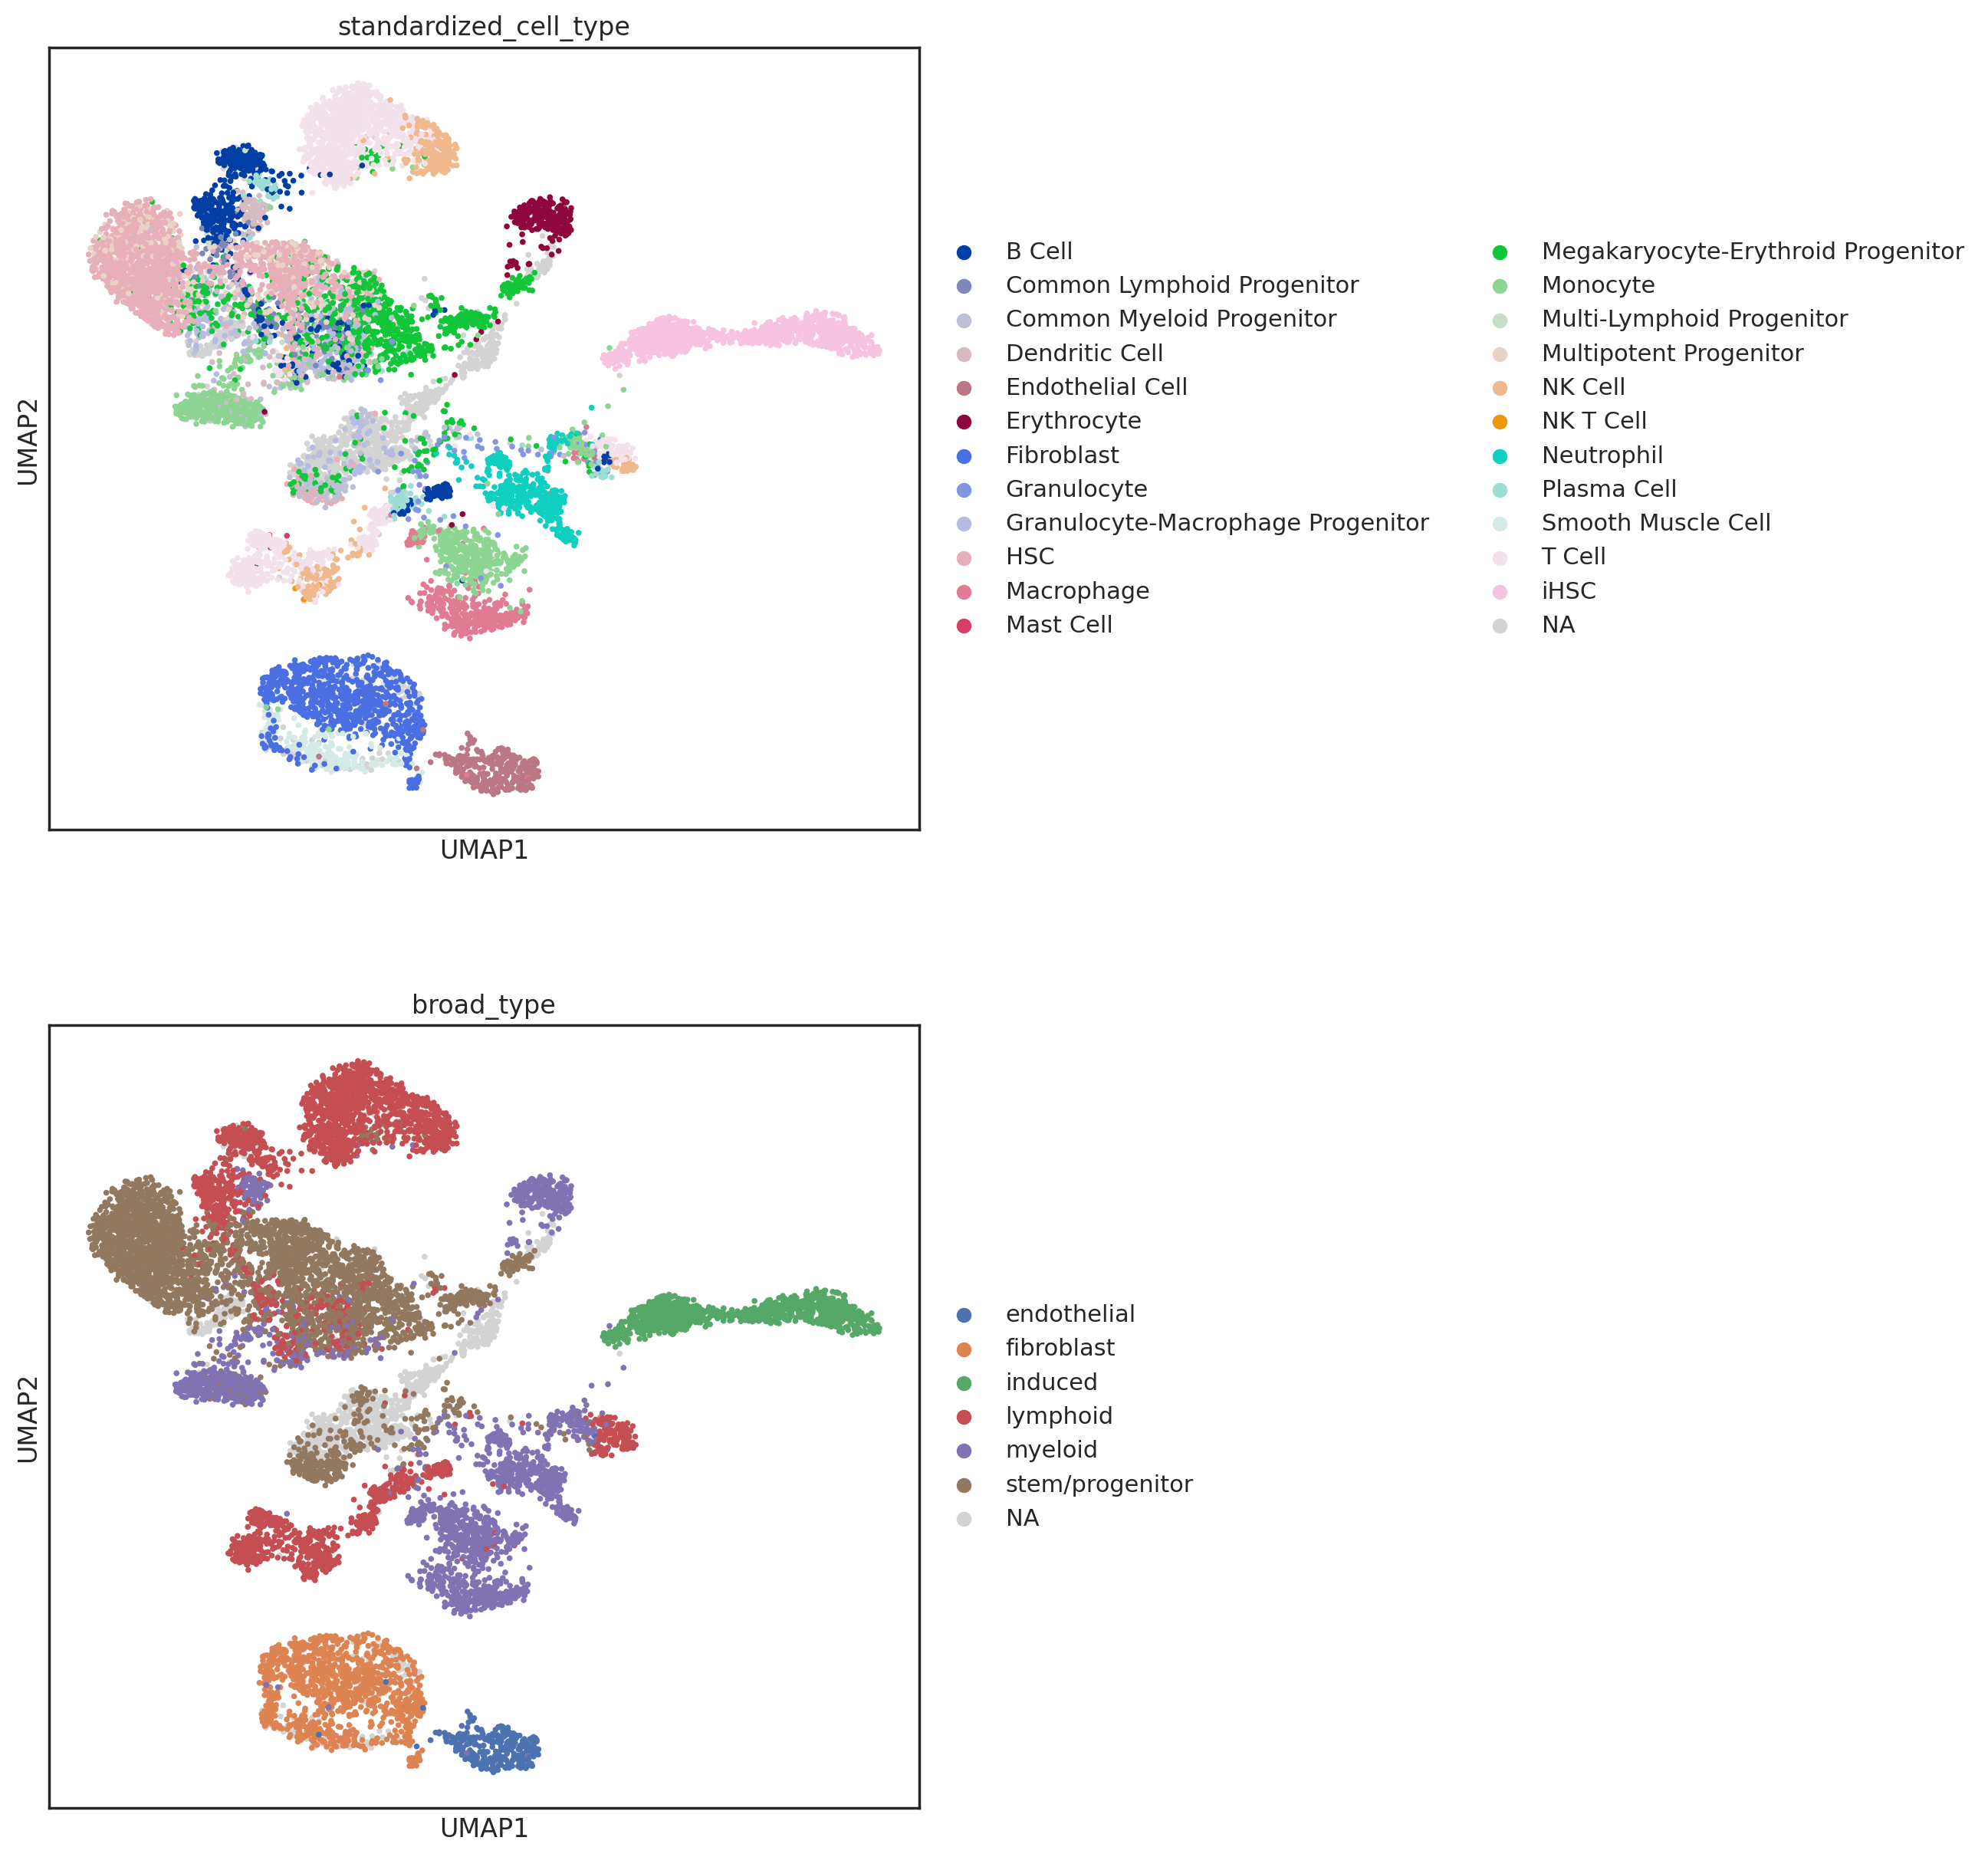

In [6]:
fpath = "../ihsc_cell_types.csv"
cell_map = pd.read_csv(fpath, comment="#")

adata.obs = pd.merge(adata.obs, 
                     cell_map,
                     how='left',
                     left_on='cell_type',
                     right_on='label',
                    )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7
sc.pl.umap(
    adata,
    color=["standardized_cell_type","broad_type"],
    ncols=1,
    size=30,
)

In [7]:
df[df['dataset'] == "pellin"]['cell_type'].value_counts()

cell_type
LinNegCD34PosCD164Pos     300
LinNegCD34NegCD164high    214
LinNegCD34lowCD164high    192
CMP                        87
HSC                        58
MEP                        51
GMP                        47
PreBNK                     26
LinNegCD34NegCD164low      12
MPP                         9
MLP                         4
Name: count, dtype: int64

# Cell Type Classification

In [9]:
def train_cell_type_classifier(adata, target_column, test_size=0.2, random_state=42, verbose=True):
    """
    Trains an XGBoost cell type classifier on anndata data.

    Handles string and numeric target columns, drops rows with missing labels.

    Args:
        adata: The AnnData object containing features in adata.X and cell types in adata.obs.
        target_column: The name of the column in adata.obs containing cell type labels.
        test_size: The proportion of data to use for the test set (default: 0.2).
        random_state: The seed for reproducibility.
        verbose: Whether to print detailed output during training (default: True).

    Returns:
        A tuple containing:
            - The trained XGBoost classifier.
            - A dictionary containing:
                - Data splits: X_train, X_test, y_train, y_test, y_pred
                - class_label_map: Mapping of encoded labels to original labels
    """
  
    if verbose:
        print(f"Starting cell type classification using XGBoost...")
        print(f"Target column: '{target_column}'")
        print(f"Number of cells: {adata.n_obs}")
        print(f"Number of features: {adata.n_vars}")
    
    # Drop rows with NaN values in the target column
    adata = adata[~adata.obs[target_column].isnull(), :].copy()  

    # Update cell count after dropping NaNs
    if verbose:
        print(f"Number of cells after dropping NaN labels: {adata.n_obs}")

    X = adata.X
    y = adata.obs[target_column].values
    class_labels = np.unique(y)  # Get unique class labels

    # Handle target columns which are strings or need re-encoding
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Ensure consecutive integer labels starting from 0
    unique_y, y_indices = np.unique(y, return_inverse=True)
    y = np.arange(len(unique_y))[y_indices]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # XGBoost Classifier
    model = xgboost.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))

    # Model training
    if verbose:
        print("Training the XGBoost model...")
    model.fit(X_train, y_train)

    # Evaluation on the test set
    if verbose:
        print("Evaluating on the test set...")
    # Evaluation on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) # get prediction probablilites
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=class_labels)

    if verbose:
        print(f"\nAccuracy on Test Set: {accuracy:.4f}")
        print(f"\nClassification Report:\n{report}")
        
    results = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'class_label_map': dict(zip(le.transform(class_labels), class_labels)) # Map encoded labels to original
    }
    
    return model, results 



model, results = train_cell_type_classifier(adata=adata,
                                  target_column='standardized_cell_type')

model

Starting cell type classification using XGBoost...
Target column: 'standardized_cell_type'
Number of cells: 12000
Number of features: 512
Number of cells after dropping NaN labels: 10860
Training the XGBoost model...


/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Evaluating on the test set...

Accuracy on Test Set: 0.8683

Classification Report:
                                    precision    recall  f1-score   support

                            B Cell       0.88      0.84      0.86       116
        Common Lymphoid Progenitor       0.54      0.41      0.46        32
         Common Myeloid Progenitor       0.54      0.49      0.51        75
                    Dendritic Cell       0.78      0.68      0.72        31
                  Endothelial Cell       1.00      1.00      1.00        61
                       Erythrocyte       1.00      1.00      1.00        53
                        Fibroblast       0.98      0.97      0.97       167
                       Granulocyte       0.86      0.86      0.86        14
 Granulocyte-Macrophage Progenitor       0.41      0.39      0.40        28
                               HSC       0.83      0.95      0.88       341
                        Macrophage       0.99      0.95      0.97        78
   

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 22, does not match size of target_names, 23
  warnings.warn(
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=23,
              num_parallel_tree=None, ...)

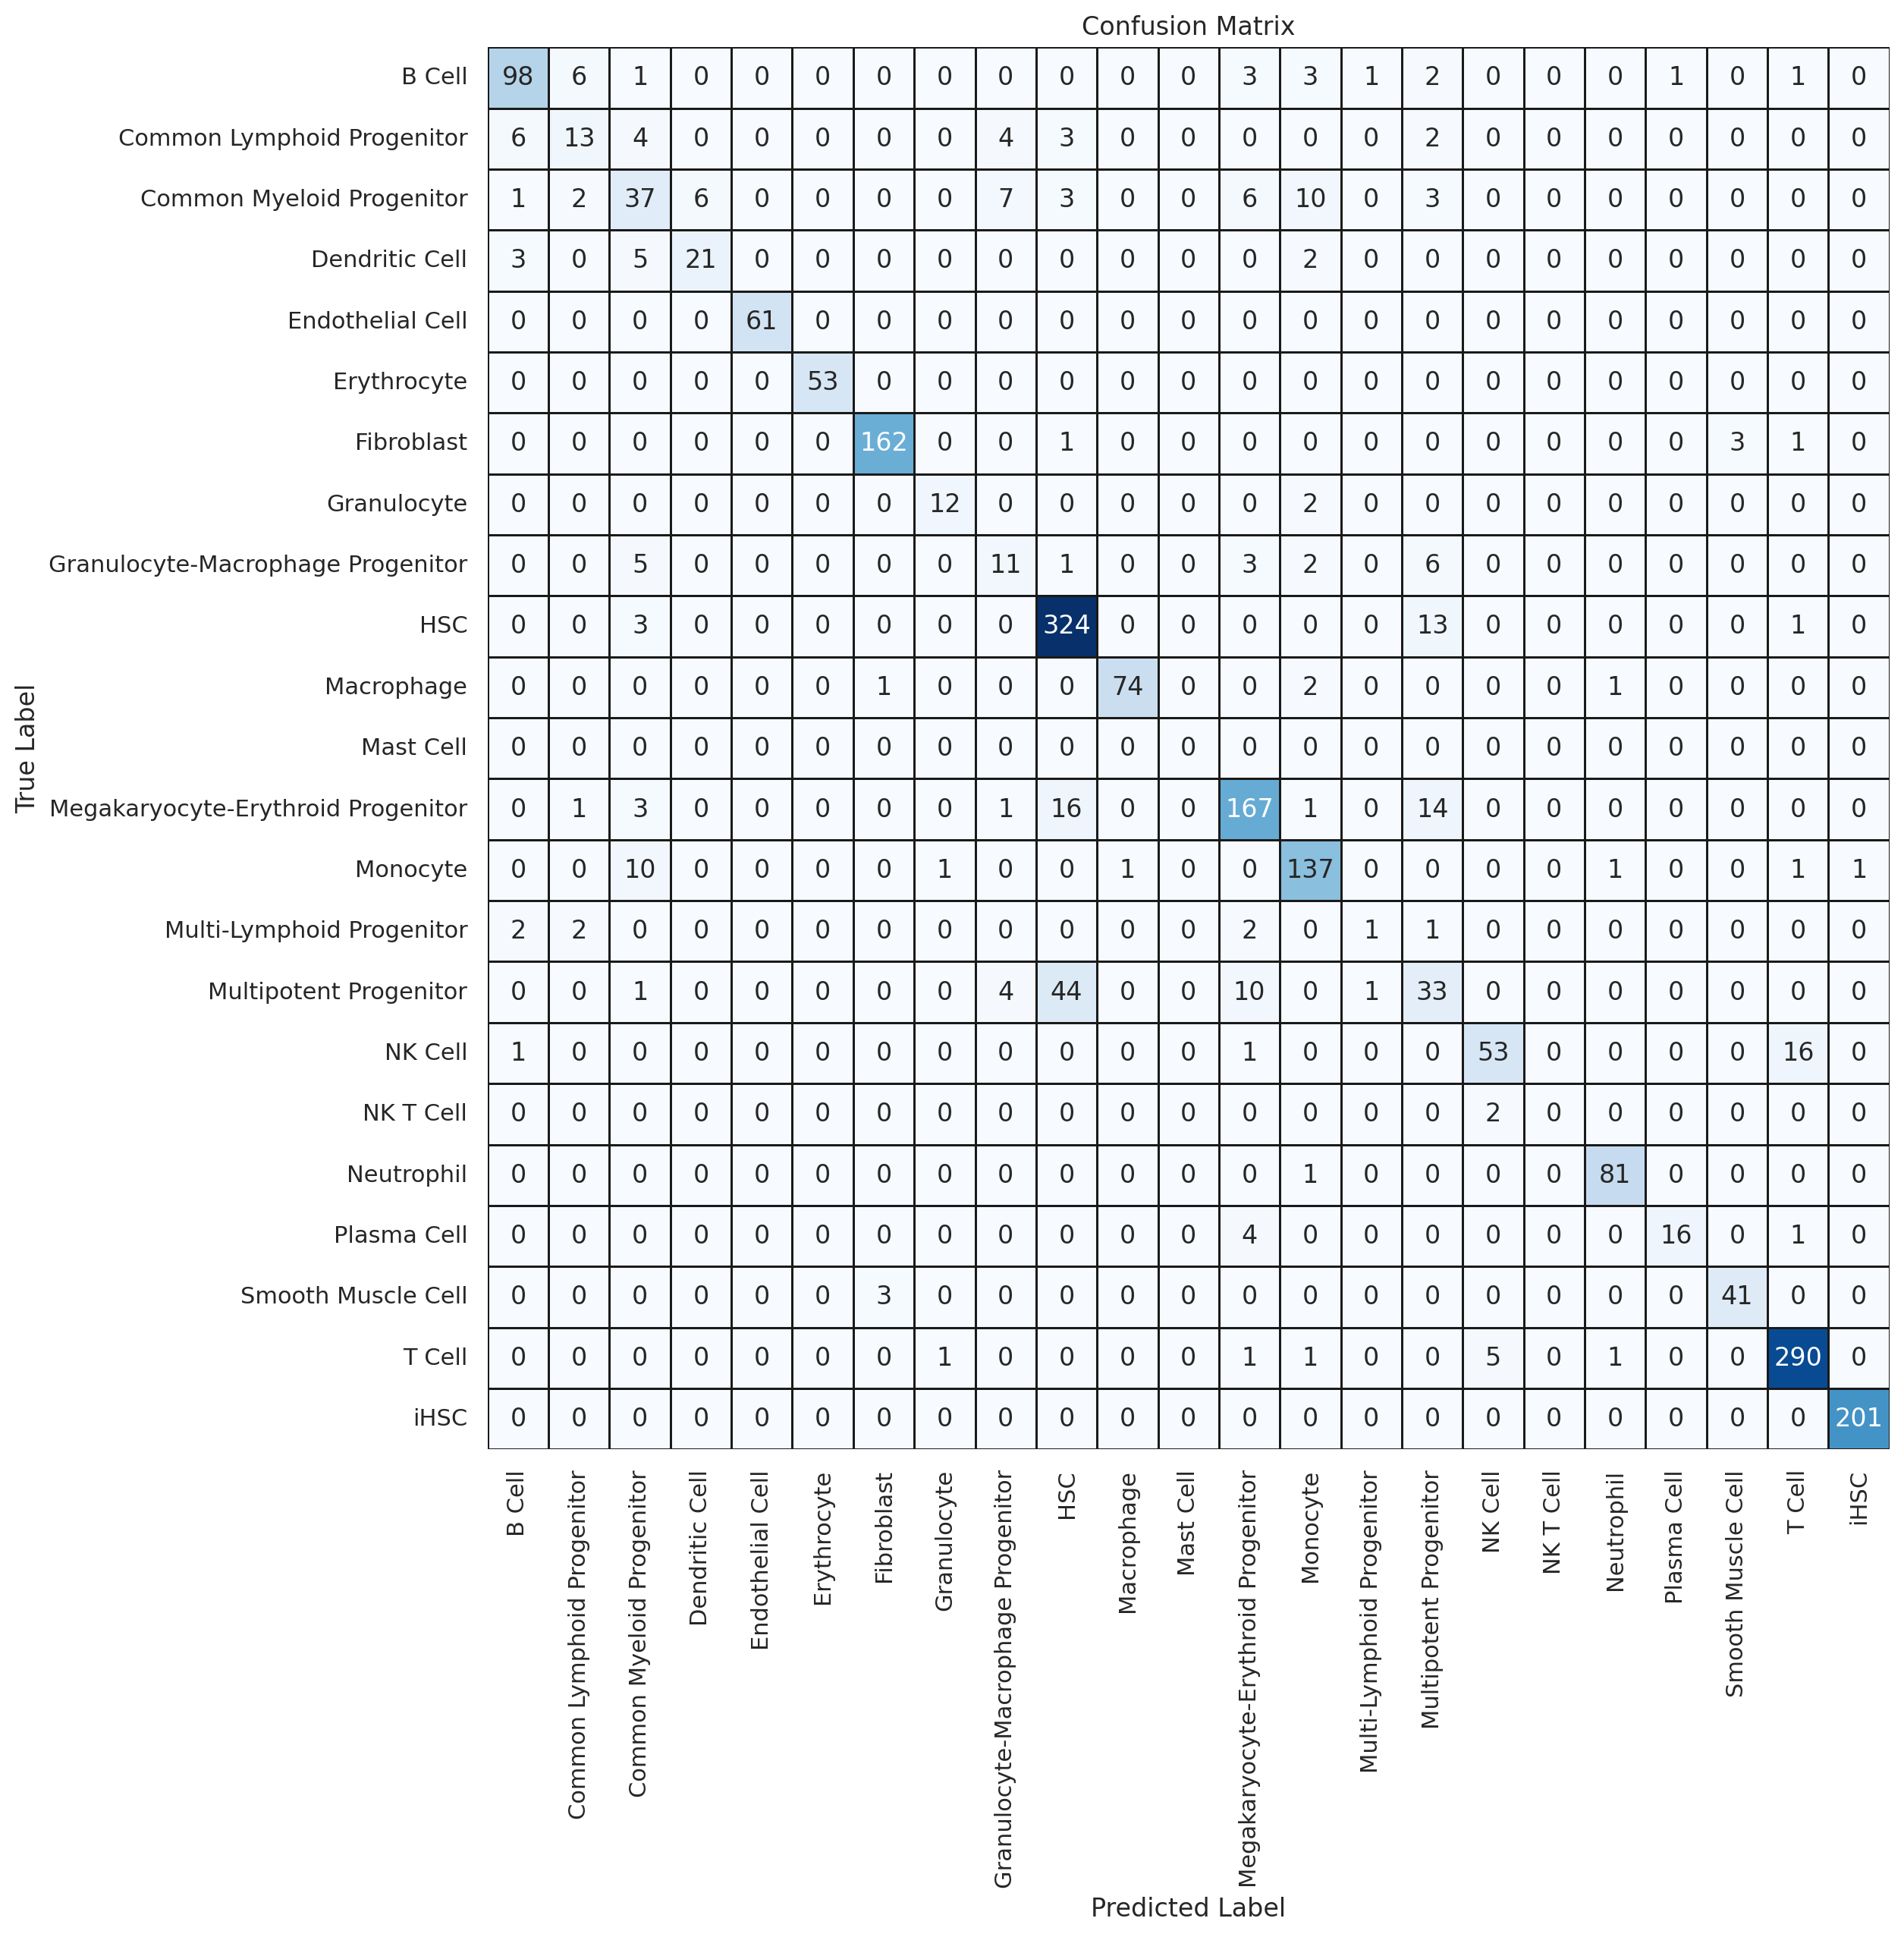

In [10]:
def plot_confusion_matrix(results):
    """
    Plots a confusion matrix using Seaborn and Matplotlib.

    Args:
        results: The dictionary returned by train_cell_type_classifier, containing:
            - y_test: True labels
            - y_pred: Predicted labels
            - class_label_map: Mapping of encoded labels to original labels
    """

    y_true = results['y_test']
    y_pred = results['y_pred']
    class_label_map = results['class_label_map']

    # Use the class_label_map to get the original labels
    y_true = [class_label_map[label] for label in y_true]
    y_pred = [class_label_map[label] for label in y_pred]
    class_names = list(class_label_map.values())  # Get original class names

    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', 
                cmap='Blues', 
                lw=0.5, linecolor='k',
                square=True,
                cbar=False,
                xticklabels=class_names, 
                yticklabels=class_names)

    # Set labels, title, and ticks
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 12
plot_confusion_matrix(results)

Text(0.5, 1.0, 'iHSC')

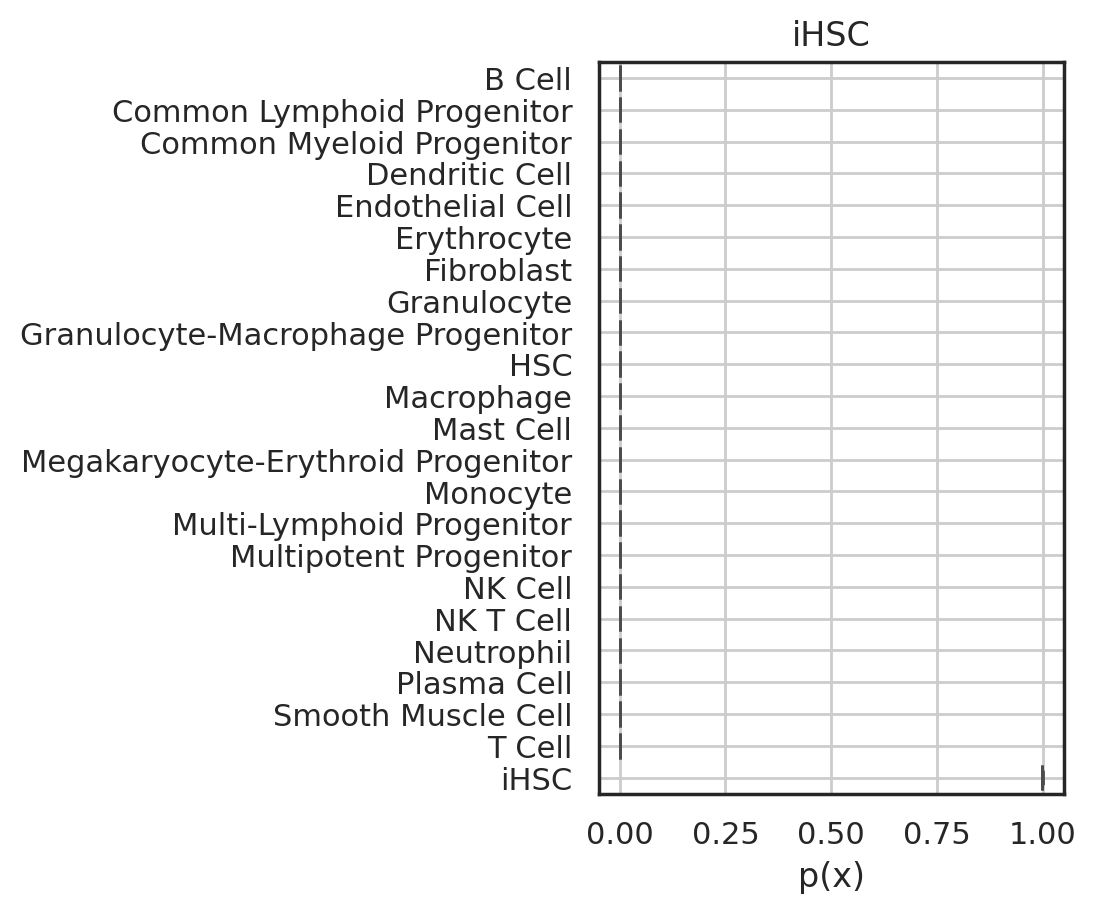

In [11]:
target_type = "iHSC"
probs = pd.DataFrame(results['y_pred_proba'], 
                     columns=list(results['class_label_map'].values()))

probs['actual'] = pd.Series(results['y_test']).map(results['class_label_map'])
probs = pd.melt(probs, id_vars='actual')

probs = probs[probs['actual'] == target_type]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4.75

sns.boxplot(data=probs, 
            x='value',
            y='variable',
            showfliers=False,
        )

plt.grid()
plt.ylabel("")
plt.xlabel("p(x)")
plt.title(target_type)

# what if we exclude the iHSC from trainning?

In [12]:
exclude = 'iHSC'
column = 'standardized_cell_type'

model, results = train_cell_type_classifier(adata=adata[adata.obs[column] != exclude, :].copy(),
                                  target_column=column)

model

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Starting cell type classification using XGBoost...
Target column: 'standardized_cell_type'
Number of cells: 11000
Number of features: 512
Number of cells after dropping NaN labels: 9860
Training the XGBoost model...
Evaluating on the test set...

Accuracy on Test Set: 0.8438

Classification Report:
                                    precision    recall  f1-score   support

                            B Cell       0.80      0.90      0.84       105
        Common Lymphoid Progenitor       0.64      0.35      0.45        40
         Common Myeloid Progenitor       0.56      0.44      0.49        75
                    Dendritic Cell       0.91      0.66      0.76        32
                  Endothelial Cell       0.98      1.00      0.99        55
                       Erythrocyte       1.00      0.98      0.99        51
                        Fibroblast       0.97      0.98      0.98       173
                       Granulocyte       0.83      0.50      0.62        10
 Granulocyte-Ma

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 21, does not match size of target_names, 22
  warnings.warn(
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/sklearn/metrics/_classification.py

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=22,
              num_parallel_tree=None, ...)

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Text(0.5, 1.0, 'iHSC')

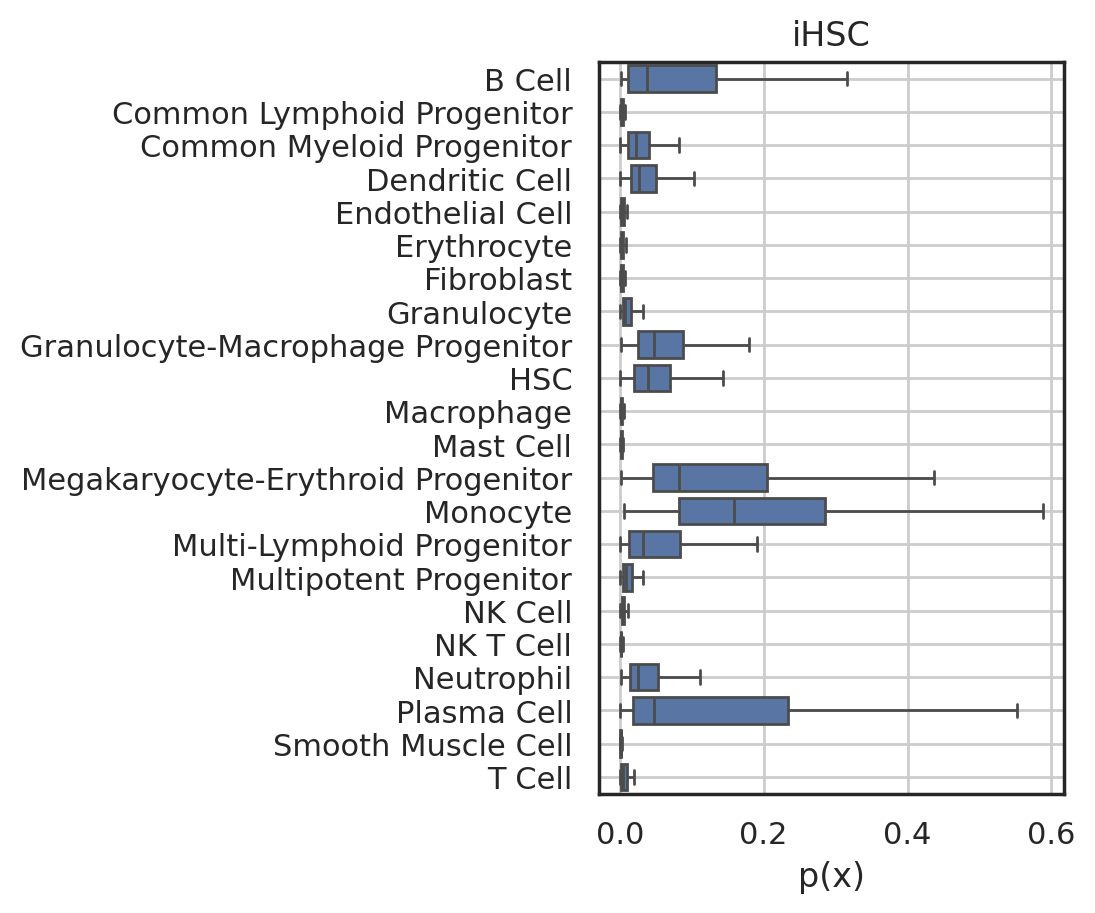

In [13]:
X = adata[adata.obs[column] == exclude, :].copy()
probs = model.predict_proba(X.X) 

probs = pd.DataFrame(probs, 
                     columns=list(results['class_label_map'].values()))

probs['actual'] = exclude
probs = pd.melt(probs, id_vars='actual')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4.75

sns.boxplot(data=probs, 
            x='value',
            y='variable',
            showfliers=False,
        )

plt.grid()
plt.ylabel("")
plt.xlabel("p(x)")
plt.title(target_type)

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
all_genes = []

for input_vec in df['input_ids'].values[0:100]:
    all_genes += list(input_vec)


print(len(set(all_genes)))

In [ ]:
break

In [ ]:
X = embs.to_numpy()
X.shape

In [ ]:
"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Bone_Marrow.dataset"
n_cells = 5000
df = gtu.load_data_as_dataframe(data_path, num_cells=n_cells)
print(f"{df.shape=}")

# convert into arrow dataset
data = Dataset.from_pandas(df)

df.head()

In [ ]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=60)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["free_annotation", "donor", "gender"],
    ncols=1,
    size=30,
)

adata


In [ ]:
break

In [ ]:
reload(gtu)
torch.cuda.empty_cache()

"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/iHSC.dataset"
n_cells = 1000
df = gtu.load_data_as_dataframe(data_path)

# convert into arrow dataset
data = Dataset.from_pandas(df)

# useful for later
features = df.columns.to_list()
features.remove("input_ids")

print(f"{df.shape=}")
df.head()

In [ ]:
reload(gtu)
torch.cuda.empty_cache()

"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/iHSC.dataset"
df = gtu.load_data_as_dataframe(data_path)

# convert into arrow dataset
data = Dataset.from_pandas(df)

# useful for later
features = df.columns.to_list()
features.remove("input_ids")

print(f"{df.shape=}")
df.head()

In [ ]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")
embs.head()

In [ ]:
break

In [ ]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    # color=["free_annotation", "compartment"],
    ncols=1,
    size=30,
)

adata

In [ ]:
sc.pl.umap(
    adata,
    color=["n_genes_by_counts"],
    ncols=1,
    size=30,
)

In [ ]:
reload(gtu)
torch.cuda.empty_cache()

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_skin.dataset"
df = gtu.load_data_as_dataframe(data_path)
df = df[df['free_annotation'] == "skeletal muscle cells"]
print(f"{df.shape=}")
data = Dataset.from_pandas(df)

# gene embedding
gene_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='gene')
print(f"{gene_embedding.shape=}")

# cell embedding
cell_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='cell')
print(f"{cell_embedding.shape=}")

# Test cell embedding anf gene embedding

In [ ]:
cell_embedding.to_numpy()[0, 0:3]

In [ ]:
test = gene_embedding.mean(axis=1)
test[0, 0:3]

In [ ]:
break